In [262]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.cluster import KMeans
import geopy

import os
import pycountry
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [15, 6]

In [83]:
# Create input, processed and output folders if they don't exist
# If the paths are relative, the correspoding folders will be created inside the current working directory.

input_directory_path = os.path.join('input')
thewindpower_input_directory_path = os.path.join('input','thewindpower')
Harmonised_global_datasets_of_wind_and_solar_input_directory_path = os.path.join('input', 'Harmonised_global_datasets_of_wind_and_solar')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(thewindpower_input_directory_path, exist_ok=True)
os.makedirs(Harmonised_global_datasets_of_wind_and_solar_input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

In [84]:
thewindpower_filename = thewindpower_input_directory_path + '/Windfarms_Europe_20180326.xls'

H_Wind_filename = Harmonised_global_datasets_of_wind_and_solar_input_directory_path + '/global_wind_2020.csv'

In [85]:
thewindpower_filename

'input/thewindpower/Windfarms_Europe_20180326.xls'

In [86]:
H_Wind_filename

'input/Harmonised_global_datasets_of_wind_and_solar/global_wind_2020.csv'

In [87]:
# load and clean TP data function

def load_H_Wind_data(fn):
    """
    Load and standardize the raw wind data file from Harmonised_global_datasets_of_wind_and_solar.

    Parameters
    ----------
    fn : str
        filename

    """
    path = fn
    df = pd.read_csv(path, sep=",",\
                     index_col='wind_id')

    #Dropping unnescessary columns
    return df.sort_index()

# load and clean PS data function

def load_thewindpower_data(fn):
    """
    Load and standardize the raw data file from thewindpower.


    Parameters
    ----------
    fn : str
        filename

    """
    
    return pd.read_excel(fn, sheet_name='Windfarms', skiprows=[1])\
           .set_index('ID')\
           .replace('#ND',np.nan)

In [88]:
# countries to analyze

countries = ['AL', 'AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK']
#, 'BA', 'MK'

countries_dic = {}
for country in pycountry.countries:
    countries_dic[country.alpha_3] = country.alpha_2

In [89]:
# load and standardize the thewindpower

thewindpower = load_thewindpower_data(thewindpower_filename)

# replace spaces in column names
thewindpower.columns = thewindpower.columns.str.replace(' ', '_')
thewindpower.columns = thewindpower.columns.str.replace('\n', '_')

# convert countries to iso 2
thewindpower = thewindpower.query('ISO_code in @countries')

# convert power to MW
thewindpower.Total_power = thewindpower.Total_power/1000

# Filter 
thewindpower = thewindpower.query('Status == "Production"')
thewindpower = thewindpower.query('Offshore_Shore_distance == "No"')

In [90]:
thewindpower.ISO_code.unique()

array(['AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR',
       'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'NL',
       'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK'], dtype=object)

In [91]:
# load and standardize the Harmonised_global_datasets_of_wind_and_solar

H_Wind = load_H_Wind_data(H_Wind_filename)

H_Wind = H_Wind.replace({"GID_0": countries_dic})

H_Wind = H_Wind.rename(columns={"GID_0": "country"})

H_Wind = H_Wind.query('country in @countries')

In [92]:
H_Wind.country.unique()

array(['GB', 'FR', 'ES', 'IE', 'PT', 'DK', 'DE', 'NL', 'EE', 'SE', 'AT',
       'CH', 'PL', 'BE', 'HU', 'CZ', 'IT', 'SK', 'LV', 'LU', 'BG', 'GR',
       'SI', 'LT', 'RO', 'NO', 'FI', 'HR', 'ME', 'RS'], dtype=object)

In [93]:
set(H_Wind.country.unique())-set(thewindpower.ISO_code.unique())

set()

In [94]:
set(thewindpower.ISO_code.unique())-set(H_Wind.country.unique())

set()

In [95]:
H_Wind.power.sum()

114558.97499519734

In [96]:
thewindpower.Total_power.sum()

144352.27899999998

In [97]:
thewindpower

,Continent,ISO_code,Country,State_code,Area,City,Name,2nd_name,Latitude,Longitude,...,Turbine,Hub_height,Number_of_turbines,Total_power,Developer,Operator,Owner,Commissioning_date,Status,Update
ID,,,,,,,,,,,,,,,,,,,,,
20222,Europe,AT,Austria,NaN,Burgenland,Albrechtsfeld,Albrechtsfeld,NaN,47.827940,17.018580,...,E101/3000,135,10.0,30.000,ImWind,Albrechtsfeld Windpower GmbH,NaN,2013,Production,2018-02-07
20505,Europe,AT,Austria,NaN,Burgenland,Andau,Andau,NaN,47.777965,17.033402,...,E101/3000,135,68.0,204.000,NaN,Energie Burgenland,Energie Burgenland/#ND,2014/08,Production,2017-10-12
21408,Europe,AT,Austria,NaN,Burgenland,Andau,Andau,NaN,47.777965,17.033402,...,E101/3000,135,11.0,33.000,Energie Burgenland,Energie Burgenland,Energie Burgenland,2013,Production,2017-07-11
26776,Europe,AT,Austria,NaN,Niederösterreich,Andlersdorf,Andlersdorf,NaN,48.176452,16.694142,...,E101/3050,NaN,3.0,9.150,NaN,NaN,Wien Energie,2017,Production,2018-02-09
24835,Europe,AT,Austria,NaN,Niederösterreich,"Andlersdorf, Orth",Andlersdorf-Orth,NaN,48.162884,16.677179,...,E101/3050,101,10.0,30.500,ImWind,NaN,Wien Energie,2017/05,Production,2018-02-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,Europe,SE,Sweden,NaN,Västra Götaland,Almestad,Zepyrus af Hov,NaN,57.997546,13.110000,...,V29/225,31,1.0,0.225,NaN,NaN,NaN,2002/02,Production,2017-09-21
20704,Europe,SI,Slovenia,NaN,NaN,Dolenja vas,Dolenja vas,NaN,45.732186,13.994457,...,E70/2300,98,2.0,4.600,OKOENERGIE GmbH,NaN,Alpen Adria Energie,2012/10,Production,2018-03-14
22348,Europe,SI,Slovenia,NaN,NaN,Razdrto,Razdrto,NaN,45.760732,14.063747,...,E44/900,NaN,1.0,0.900,NaN,NaN,NaN,2014,Production,2015-04-20


In [98]:
H_Wind

,X,Y,country,turbines,landscape.area,water,urban,power
wind_id,,,,,,,,
1866,-4.933236e+04,6.303608e+06,GB,1,2.010619,0,0,NaN
1867,-7.777747e+04,6.211812e+06,GB,1,2.010619,0,1,NaN
1868,-1.892116e+04,6.229784e+06,GB,1,2.010619,0,1,NaN
1869,-9.809263e+04,6.525381e+06,GB,1,2.010619,0,0,NaN
1870,-5.938467e+03,6.289412e+06,GB,1,2.010619,0,1,NaN
...,...,...,...,...,...,...,...,...
33500,2.266151e+05,6.074098e+06,FR,16,5.623193,0,0,20.766971
33501,3.462596e+05,6.239928e+06,NL,82,3.271772,0,0,1.383168
33502,1.700846e+05,6.073824e+06,FR,5,3.574766,0,0,8.397891


In [99]:
H_Wind[['turbines','power','country','X','Y']].groupby(['country'])\
                                                .agg({\
                                                    'turbines': ['sum','mean', 'count', 'size'],
                                                    'power' : ['sum','mean', 'count', 'size'],
                                                    'X' : ['count', 'size'],
                                                    'Y' : ['count', 'size']})

turbines                                power                         \
             sum       mean count  size           sum       mean count  size   
country                                                                        
AT          1398   8.737500   160   160   1854.647555  28.100721    66   160   
BE           915   4.103139   223   223    634.193318  13.786811    46   223   
BG           470   4.895833    96    96    480.013254  17.778269    27    96   
CH            92   2.190476    42    42     41.010380  10.252595     4    42   
CZ           217   3.191176    68    68    143.128364  11.927364    12    68   
DE         28708   6.172436  4651  4651  34821.204505  20.776375  1676  4651   
DK          5926   2.518487  2353  2353   3880.934014  13.290870   292  2353   
EE           137   4.724138    29    29    134.932078  22.488680     6    29   
ES         19562  17.280919  1132  1132  24205.693426  28.954179   836  1132   
FI           660   3.041475   217   217    531.116094  16.094427    33   217   
FR         11355   8.337004  1362  1362  10950.039603  14.541885   753  1362   
GB         14727  10.982103  1341  1341   8670.325522  26.353573   329  1341   
GR          1915   9.527363   201   201   2518.852655  18.520975   136   201   
HR           272   5.913043    46    46    409.473103  17.061379    24    46   
HU           190   3.958333    48    48    240.191627  21.835602    11    48   
IE          1728   8.267943   209   209   2386.308861  23.626820   101   209   
IT          6607   8.774236   753   753   8464.655361  25.043359   338   753   
LT           316   3.009524   105   105    289.531522  20.680823    14   105   
LU            73   2.027778    36    36     36.751601  12.250534     3    36   
LV            84   3.500000    24    24     82.712202  13.785367     6    24   
ME            50  10.000000     5     5     89.423666  29.807889     3     5   
NL          2886   5.714851   505   505   2120.664151  20.588972   103   505   
NO          1093   9.262712   118   118   1773.492307  32.245315    55   118   
PL          3310   3.201161  1034  1034   2951.516730  16.306722   181  1034   
PT          2683   8.008955   335   335   3948.948676  20.147697   196   335   
RO           637   9.367647    68    68    625.269748  34.737208    18    68   
RS            12   2.000000     6     6      0.000000        NaN     0     6   
SE          2367   3.597264   658   658   2273.944670  19.773432   115   658   
SI            16   1.142857    14    14      0.000000        NaN     0    14   
SK            10   1.428571     7     7      0.000000        NaN     0     7   

            X           Y        
        count  size count  size  
country                          
AT        160   160   160   160  
BE        223   223   223   223  
BG         96    96    96    96  
CH         42    42    42    42  
CZ         68    68    68    68  
DE       4651  4651  4651  4651  
DK       2353  2353  2353  2353  
EE         29    29    29    29  
ES       1132  1132  1132  1132  
FI        217   217   217   217  
FR       1362  1362  1362  1362  
GB       1341  1341  1341  1341  
GR        201   201   201   201  
HR         46    46    46    46  
HU         48    48    48    48  
IE        209   209   209   209  
IT        753   753   753   753  
LT        105   105   105   105  
LU         36    36    36    36  
LV         24    24    24    24  
ME          5     5     5     5  
NL        505   505   505   505  
NO        118   118   118   118  
PL       1034  1034  1034  1034  
PT        335   335   335   335  
RO         68    68    68    68  
RS          6     6     6     6  
SE        658   658   658   658  
SI         14    14    14    14  
SK          7     7     7     7

In [100]:
thewindpower[['Hub_height', 'Number_of_turbines', 'Total_power', 'ISO_code', 'Latitude', 'Longitude']].groupby(['ISO_code'])\
                                                                                                      .agg(['sum','mean', 'count', 'size'\
                                                                                                          ])

Number_of_turbines                        Total_power             \
                        sum       mean count  size         sum       mean   
ISO_code                                                                    
AT                   1206.0   4.483271   269   271    2683.677   9.902867   
BE                    760.0   3.234043   235   235    1695.450   7.214681   
BG                    334.0   4.704225    71    77     644.445   8.950625   
CH                     37.0   1.947368    19    19      75.050   3.950000   
CZ                    196.0   2.305882    85    85     306.910   3.610706   
DE                  27109.0   3.535342  7668  7987   42642.592   5.347704   
DK                   4144.0   1.868350  2218  2219    4154.862   1.872403   
EE                    136.0   4.533333    30    30     309.910  10.330333   
ES                  20125.0  17.715669  1136  1142   23301.390  20.404019   
FI                    590.0   3.734177   158   158    1655.630  10.478671   
FR                   6711.0   5.550868  1209  1209   13010.195  10.787890   
GB                   6100.0   6.939704   879   881   11231.790  12.748910   
GR                   1328.0  10.624000   125   192    2148.550  11.190365   
HR                    226.0  10.761905    21    22     466.000  21.181818   
HU                    199.0   4.234043    47    49     384.975   7.856633   
IE                   1664.0   7.775701   214   230    3039.495  13.215196   
IT                   7236.0  11.842881   611   632   10469.340  16.565411   
LT                    156.0   3.120000    50    68     379.905   5.670224   
LU                     66.0   2.750000    24    24     127.400   5.308333   
LV                     50.0   5.555556     9    11      53.100   4.827273   
ME                     26.0  26.000000     1     1      72.800  72.800000   
NL                   2282.0   3.532508   646   646    3474.785   5.378924   
NO                    468.0  11.700000    40    40    1151.400  28.785000   
PL                   2288.0   8.766284   261   301    5687.033  18.893797   
PT                   2772.0   6.476636   428   429    5386.600  12.556177   
RO                   1091.0  17.317460    63   105    3579.225  34.087857   
RS                     10.0   2.500000     4     4      25.000   6.250000   
SE                   3174.0   3.037321  1045  1052    6186.130   5.880352   
SI                      3.0   1.500000     2     2       5.500   2.750000   
SK                      5.0   2.500000     2     2       3.140   1.570000   

                           Latitude                            Longitude  \
         count  size            sum       mean count  size           sum   
ISO_code                                                                   
AT         271   271   12854.067127  48.142574   267   271   4353.414767   
BE         235   235   11889.576533  50.810156   234   235   1041.686287   
BG          72    77    3195.764467  43.186006    74    77   2023.099960   
CH          19    19     889.626397  46.822442    19    19    147.172124   
CZ          85    85    4206.677782  50.079497    84    85   1281.534568   
DE        7974  7987  387166.006855  52.003493  7445  7987  75092.830721   
DK        2219  2219  107160.574121  55.870998  1918  2219  18990.817670   
EE          30    30    1760.742151  58.691405    30    30    716.831088   
ES        1142  1142   43682.485046  40.260355  1085  1142  -4882.013667   
FI         158   158    9794.726550  63.191784   155   158   3641.298583   
FR        1206  1209   56442.748280  46.840455  1205  1209   3606.888752   
GB         881   881   41265.513550  54.728798   754   881  -2430.271557   
GR         192   192    6437.957971  37.870341   170   192   4178.806371   
HR          22    22     614.404912  43.886065    14    22    224.805563   
HU          49    49    2330.847391  47.568314    49    49    873.379574   
IE         230   230   10585.985059  53.195905   199   230  -1643.328294   
IT         632   632   

In [101]:
power_per_country = pd.DataFrame()

In [102]:
power_per_country['H_Wind'] = H_Wind.groupby(['country']).sum().power

In [103]:
power_per_country['thewindpower'] = thewindpower.groupby(['ISO_code']).sum().Total_power

In [104]:
power_per_country['dif'] = power_per_country['H_Wind'] - power_per_country['thewindpower']

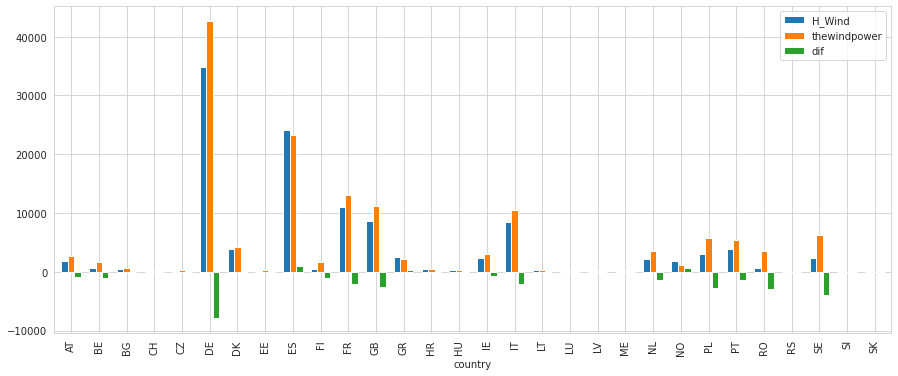

In [105]:
power_per_country.plot.bar(width=0.7)

In [106]:
power_per_country


,H_Wind,thewindpower,dif
country,,,
AT,1854.647555,2683.677,-829.029445
BE,634.193318,1695.450,-1061.256682
BG,480.013254,644.445,-164.431746
CH,41.010380,75.050,-34.039620
CZ,143.128364,306.910,-163.781636
DE,34821.204505,42642.592,-7821.387495
DK,3880.934014,4154.862,-273.927986
EE,134.932078,309.910,-174.977922
ES,24205.693426,23301.390,904.303426


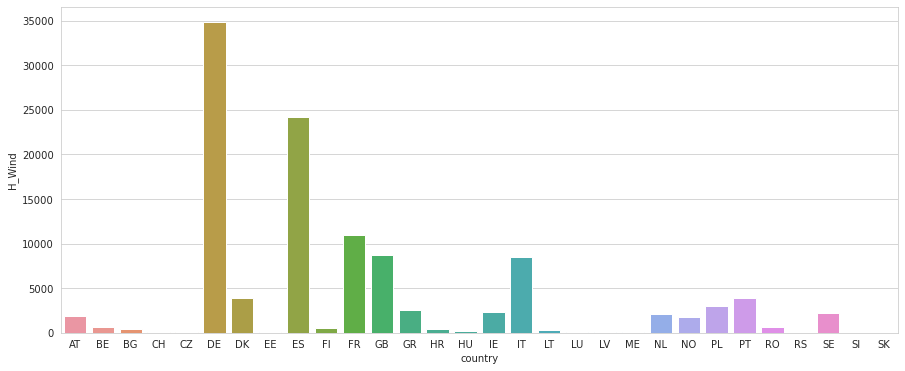

In [107]:
plot = sns.barplot(x=power_per_country.index, y='H_Wind' ,data=power_per_country)

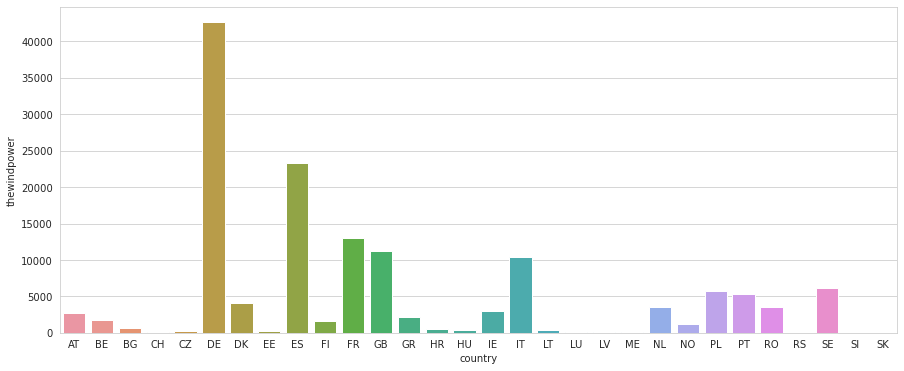

In [108]:
plot = sns.barplot(x=power_per_country.index, y='thewindpower', data=power_per_country)

In [116]:
from pyproj import CRS
crs_4326 = CRS.from_epsg(4326)

crs_4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [117]:
crs_eck4 = CRS.from_proj4('+proj=eck4')

crs_eck4
#crs_4326
#    inProj = Proj('+proj=eck4')
#    outProj = Proj('epsg:4326')

<Projected CRS: +proj=eck4 +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Eckert IV
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [122]:
from pyproj import Transformer
transformer = Transformer.from_crs(crs_eck4, crs_4326, always_xy=True)
transformer

<Concatenated Operation Transformer: pipeline>
Description: Inverse of unknown + axis order change (2D) + axis order change (2D)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)

In [171]:
H_Wind_lat_lon = transformer.transform(H_Wind['X'].to_list(), H_Wind['Y'].to_list()) 

H_Wind['Lon'] = list(H_Wind_lat_lon[0])
H_Wind['Lat'] = list(H_Wind_lat_lon[1])

H_Wind

,X,Y,country,turbines,landscape.area,water,urban,power,Lon,Lat
wind_id,,,,,,,,,,
1866,-4.933236e+04,6.303608e+06,GB,1,2.010619,0,0,NaN,-0.629603,52.362522
1867,-7.777747e+04,6.211812e+06,GB,1,2.010619,0,1,NaN,-0.985582,51.418656
1868,-1.892116e+04,6.229784e+06,GB,1,2.010619,0,1,NaN,-0.240095,51.602423
1869,-9.809263e+04,6.525381e+06,GB,1,2.010619,0,0,NaN,-1.275230,54.700611
1870,-5.938467e+03,6.289412e+06,GB,1,2.010619,0,1,NaN,-0.075705,52.215692
...,...,...,...,...,...,...,...,...,...,...
33500,2.266151e+05,6.074098e+06,FR,16,5.623193,0,0,20.766971,2.842523,50.026184
33501,3.462596e+05,6.239928e+06,NL,82,3.271772,0,0,1.383168,4.397199,51.706366
33502,1.700846e+05,6.073824e+06,FR,5,3.574766,0,0,8.397891,2.133396,50.023445


In [253]:
thewindpower.Latitude.isna().sum()

0

In [249]:
H_Wind.Lat.isna().sum()

0

In [252]:
thewindpower.dropna(axis=0, how='any', subset=['Latitude', 'Longitude'], inplace=True)

In [258]:
X_H_Wind=H_Wind.loc[H_Wind.country == 'DE',['power','Lat','Lon']]


In [259]:
X_H_Wind.power.sum()

34821.204504939815

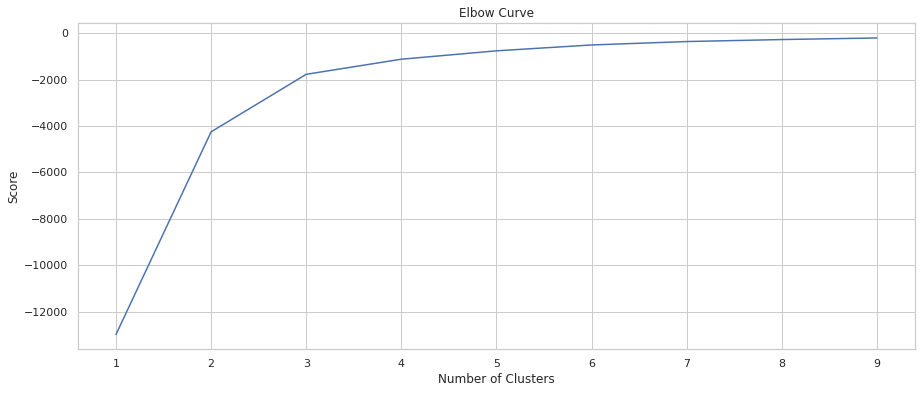

In [263]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = X_H_Wind[['Lat']]

X_axis = X_H_Wind[['Lon']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]# Visualize

plt.plot(K_clusters, score)

plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [267]:
kmeans = KMeans(n_clusters = 10, init ='k-means++')

kmeans.fit(X_H_Wind[X_H_Wind.columns[1:3]]) # Compute k-means clustering.

X_H_Wind['cluster_label'] = kmeans.fit_predict(X_H_Wind[X_H_Wind.columns[1:3]])

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(X_H_Wind[X_H_Wind.columns[1:3]]) # Labels of each point

X_H_Wind.head(10)

,power,Lat,Lon,cluster_label
wind_id,,,,
2703,NaN,51.641937,7.479929,1
2704,NaN,53.543102,7.289743,4
2705,NaN,52.741611,13.437073,6
2706,NaN,49.057083,12.113049,5
2707,NaN,50.964562,6.146188,1
2708,NaN,50.932473,6.215053,1
2709,NaN,50.895980,8.086927,8
2710,NaN,51.060443,13.574341,9
2711,NaN,52.145161,8.718964,8


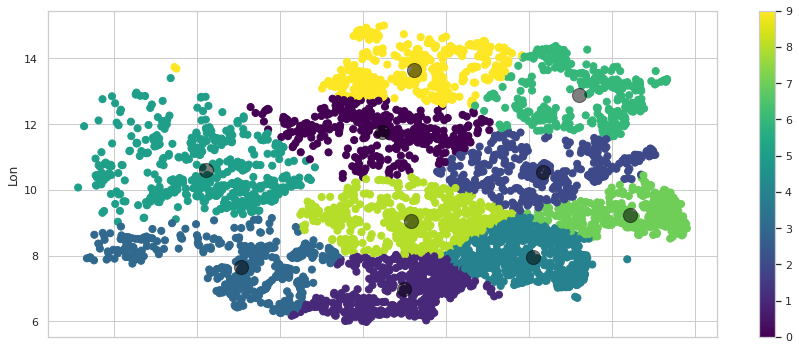

In [268]:
X_H_Wind.plot.scatter(x = 'Lat', y = 'Lon', c=labels, s=50, cmap='viridis')

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [270]:
thewindpower

,Continent,ISO_code,Country,State_code,Area,City,Name,2nd_name,Latitude,Longitude,...,Hub_height,Number_of_turbines,Total_power,Developer,Operator,Owner,Commissioning_date,Status,Update,zipcode
ID,,,,,,,,,,,,,,,,,,,,,
20222,Europe,AT,Austria,NaN,Burgenland,Albrechtsfeld,Albrechtsfeld,NaN,47.827940,17.018580,...,135,10.0,30.000,ImWind,Albrechtsfeld Windpower GmbH,NaN,2013,Production,2018-02-07,7131
20505,Europe,AT,Austria,NaN,Burgenland,Andau,Andau,NaN,47.777965,17.033402,...,135,68.0,204.000,NaN,Energie Burgenland,Energie Burgenland/#ND,2014/08,Production,2017-10-12,7163
21408,Europe,AT,Austria,NaN,Burgenland,Andau,Andau,NaN,47.777965,17.033402,...,135,11.0,33.000,Energie Burgenland,Energie Burgenland,Energie Burgenland,2013,Production,2017-07-11,7163
26776,Europe,AT,Austria,NaN,Niederösterreich,Andlersdorf,Andlersdorf,NaN,48.176452,16.694142,...,NaN,3.0,9.150,NaN,NaN,Wien Energie,2017,Production,2018-02-09,2304
24835,Europe,AT,Austria,NaN,Niederösterreich,"Andlersdorf, Orth",Andlersdorf-Orth,NaN,48.162884,16.677179,...,101,10.0,30.500,ImWind,NaN,Wien Energie,2017/05,Production,2018-02-09,2301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,Europe,SE,Sweden,NaN,Västra Götaland,Almestad,Zepyrus af Hov,NaN,57.997546,13.110000,...,31,1.0,0.225,NaN,NaN,NaN,2002/02,Production,2017-09-21,52442
20704,Europe,SI,Slovenia,NaN,NaN,Dolenja vas,Dolenja vas,NaN,45.732186,13.994457,...,98,2.0,4.600,OKOENERGIE GmbH,NaN,Alpen Adria Energie,2012/10,Production,2018-03-14,6224
22348,Europe,SI,Slovenia,NaN,NaN,Razdrto,Razdrto,NaN,45.760732,14.063747,...,NaN,1.0,0.900,NaN,NaN,NaN,2014,Production,2015-04-20,6225


In [271]:
X_thwindpower=thewindpower.loc[thewindpower.ISO_code == 'DE',['Total_power','Latitude','Longitude']]

In [ ]:
kmeans = KMeans(n_clusters = 10, init ='k-means++')

kmeans.fit(X_thwindpower[X_thwindpower.columns[1:3]]) # Compute k-means clustering.

X_thwindpower['cluster_label'] = kmeans.fit_predict(X_thwindpower[X_thwindpower.columns[1:3]])

centers_2 = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(X_thwindpower[X_thwindpower.columns[1:3]]) # Labels of each point

X_thwindpower.head(10)

In [172]:
def get_zipcode(i, geolocator, lat_field, lon_field):
    try:
        location = geolocator.reverse((i[lat_field], i[lon_field]))
        return location.raw['address']['postcode']
    except:
        return np.nan


geolocator = geopy.Nominatim(user_agent='my-application')

#example
df = pd.DataFrame({
    'Lat': [29.39291, 29.39923, 29.40147, 29.38752, 29.39291, 29.39537, 29.39343, 29.39291, 29.39556],
    'Lon': [-98.50925, -98.51256, -98.51123, -98.52372, -98.50925, -98.50402, -98.49707, -98.50925, -98.53148]
})
zipcodes = df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')

In [173]:
thewindpower['zipcode'] = thewindpower.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')

In [174]:
H_Wind['zipcode'] = H_Wind.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')

In [177]:
thewindpower.ISO_code.unique()

array(['AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR',
       'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'NL',
       'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK'], dtype=object)

In [181]:
thewindpower_DE = thewindpower[thewindpower.ISO_code =='DE']
thewindpower_DE['zipcode'].isna().sum()

726

In [184]:
H_Wind_DE = H_Wind[H_Wind.country == 'DE']
H_Wind_DE['zipcode'].isna().sum()

409

In [227]:
H_Wind_DE_agg = H_Wind_DE[['turbines','power','country','X','Y','zipcode']].groupby(['zipcode'])\
                                                .agg({\
                                                    'turbines': ['sum','mean', 'count', 'size'],
                                                    'power' : ['sum','mean', 'count', 'size'],
                                                    'X' : ['count', 'size'],
                                                    'Y' : ['count', 'size']})
Data_1 = H_Wind_DE_agg['power']['sum']
Data_1 = Data_1.to_frame()
Data_1.rename(columns={"sum": "H_Wind"}, inplace=True)

In [226]:
thewindpower_DE_agg =thewindpower_DE[['Hub_height', 'Number_of_turbines', 'Total_power', 'ISO_code', 'Latitude', 'Longitude', 'zipcode']].groupby(['zipcode'])\
                                                                                                      .agg(['sum','mean', 'count', 'size'\
                                                                                                          ])
Data_2 = thewindpower_DE_agg['Total_power']['sum']
Data_2 = Data_2.to_frame()
Data_2.rename(columns={"sum": "the_wind_power"}, inplace=True)

In [228]:
Data_3 = pd.concat([Data_1, Data_2], axis=1)


In [234]:
Data_3 = Data_3.dropna()
Data_3.the_wind_power.sum()

31709.542

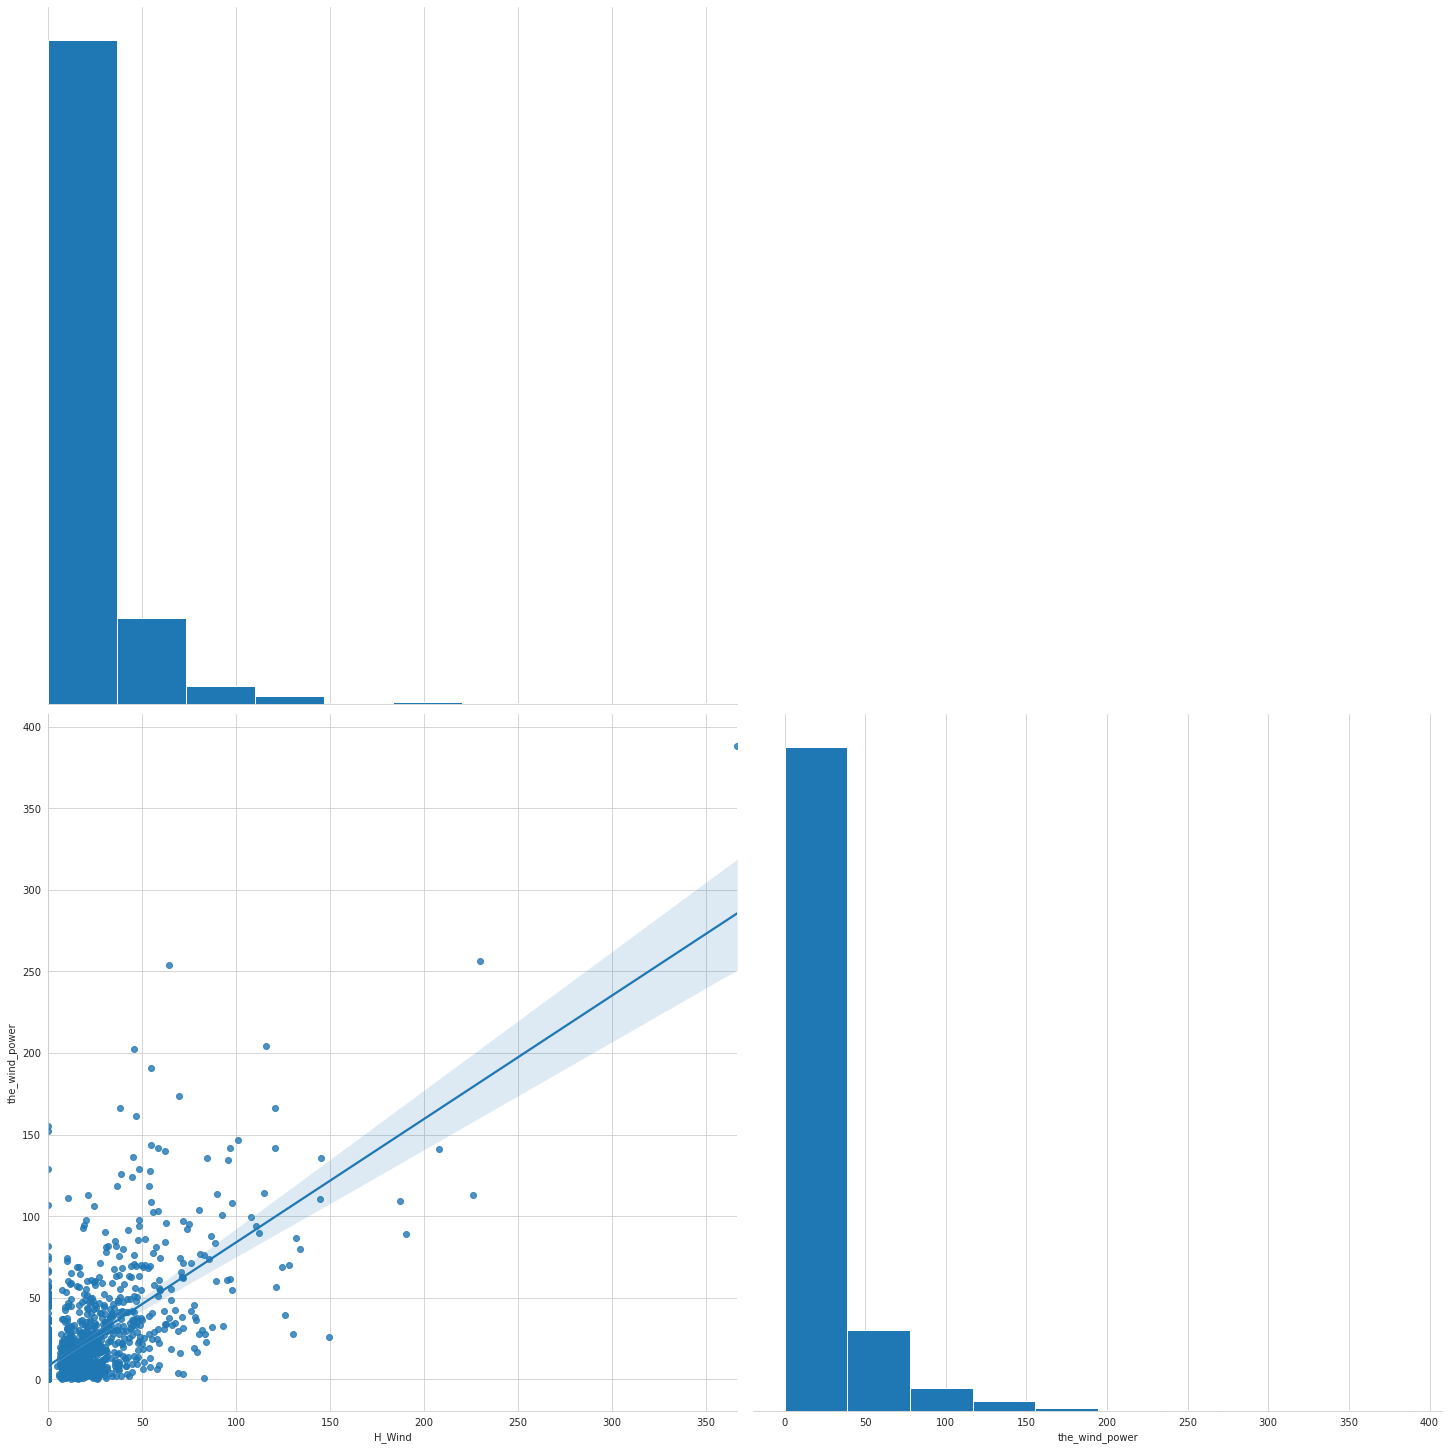

In [243]:
import seaborn as sns
#g = sns.FacetGrid(col="day", height=4, aspect=.5)
g = sns.pairplot(Data_3, dropna=True, corner=True, kind="reg", height=10)